# Introduction à l'apprentissage par renforcement
# TP 1 - le bandit-manchot multi-bras

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Définition des vaccins

In [2]:
import multiarmbandits as mab
import numpy as np
import matplotlib.pyplot as plt

In [3]:
K = 5
T = 100
np.random.seed(1)
means = np.random.random(K)
MAB = [mab.ArmBernoulli(m) for m in means]
assert(MAB[0].mean == means[0])

**Vaccins :** ils sont notés $A_k\leq K$, leur probabilité d'immunisation est $p_k = \mu_k$.

**Récompense :** 1 si le patient $t$ est immunisé et 0 sinon.

**Action optimale :** choisir le vaccin $a$ avec la meilleure probabilité $a^* = \arg\max_{a\leq K} \mu_{a}$.

**Regret :** $R_T =T\mu_a^* - \mathbb{E} \left[ \sum_{t=1}^T r_t \right]$
En notant $N_a(t)$, le nombre de fois que le vaccin $a$ a été choisi jusqu'à $t$ et $\Delta_a = \mu_a^* - \mu_a$, le regret s'exprime :

$$R_T = \sum_{a=1}^K \Delta_a \mathbb{E} \left[ N_{a_T} \right]$$


**Expliquez ce que signifie le regret concrètement. Pourquoi minimiser le regret donne une bonne solution au problème du bandit-manchot**

Le regret représente la différence entre le nombre de personne maximal qui aurait pu être sauvé en choisissant à chaque fois le vaccin optimal et le nombre de personne qui ont été sauvé en testant les vaccins. Minimiser le regret permet de trouver le vaccin optimal.

In [4]:
import multiarmbandits as mab

# Solution naive

 La solution naive consiste en 2 étapes distinctes :

1. Entraînement : on teste les K vaccins sur N patients et on note leur efficacité séparemment
2. Exploitation : le vaccin qui apparaît comme le meilleur est choisi pour les T-N patients restants.

**Implémentez cet algorithme avec T=100, N=20, K=5. Quel vaccin a été choisi lors de la seconde phase ?**

In [5]:
best_arm_idx, score = mab.simulate(MAB, T, 20)
print(f"Best arm: {best_arm_idx}, score: {score}")

Best arm: 1, score: 65


**Obtenez-vous toujours le résultat ? Testez l'algorithme avec une valeur de N plus faible. Qu'en concluez-vous ?**

In [6]:
best_arm_idx, score = mab.simulate(MAB, T, N=10)
print(f"Best arm: {best_arm_idx}, score: {score}")

Best arm: 1, score: 67


Le choix du meilleur vaccin peut changé lorsqu'on change N. Le score est donc influé par notre choix de N. Il faut trouver la plus petite valeur de N possible pour avoir un score optimal.

**Tracez l'évolution du regret $r_t$ de votre algorithme en fonction du résultat obtenu avec le patient $t<T$ sur plusieurs expériences. Représentez l'évolution moyenne de ce regret sur plusieurs expériences.**

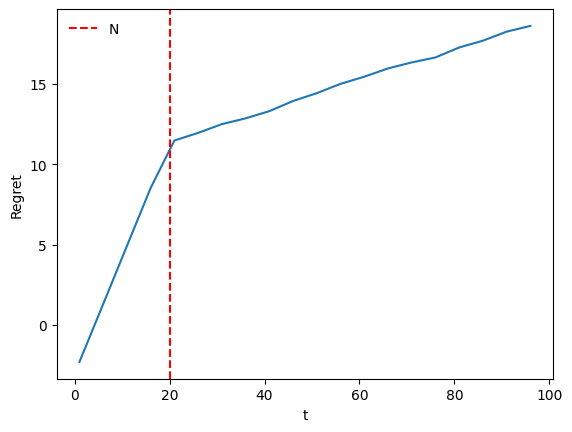

In [7]:
# Let's see how the regret evolves with t < T
mab.visualize_regret(MAB, T, N=20)

Le regret augmente drastiquement jusqu'à l'arrêt de l'entraînement.

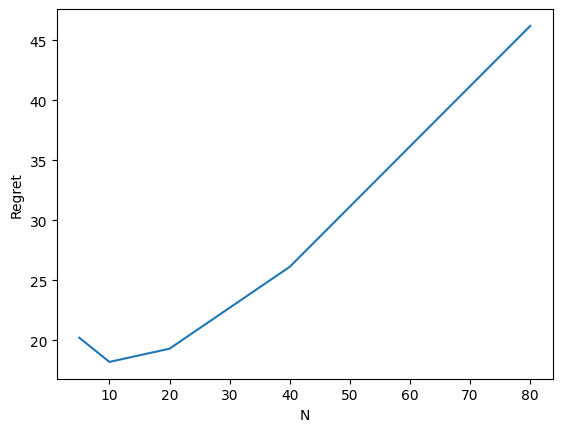

In [8]:
# Affiche le regret pour T patients selon différentes valeurs de N
N = [5, 10, 20, 40, 80]
y = []
for n in N:
    y.append(np.sum([mab.regret(MAB, T, n) for _ in range(20)])/20)
plt.plot(N, y)
plt.xlabel("N")
plt.ylabel("Regret")
plt.show()

Un choix de N=10 semble optimal pour la solution naive.

## Upper Confidence Bounds (P. Auer, 2002)

L'action $a_t$ l'instant $t$ est donnée par : 

$$a_t = max_a \left[ X_t(a) + B_t(a) \right]$$

où $X_t(a)$ est la moyenne empirique de la récompense obtenue avec le vaccin $a$ et $B_t(a)$ est un biais :

$$B_t(a) = \sqrt{ \frac{2\log t}{T_a}}$$
où $T_a$ est le nombre de fois que le vaccin $a$ a été choisi.

**Pourquoi cet algorithme n'a pas besoin d'une phase d'entraînement ? Quel terme favorise l'exploration et quel terme favorise l'exploitation ?**

Cet algorithme n'a pas besoin d'une phase d'entraînement car il utilise un biais $B_t(a)$ qui permet de faire l'entraînement en même temps que l'exploitation. Le terme $X_t(a)$ favorise l'exploitation et le terme $B_t(a)$ favorise l'exploration.

**Implémentez l'algorithme et tracez l'évolution du regret à partir de cet algorithme.**

In [9]:
best_arm_idx, score = mab.simulate_UCB(MAB, T)
print(f"Best arm: {best_arm_idx}, score: {score}")

Best arm: 1, score: 70


On remarque un score meilleur que la solution naive.

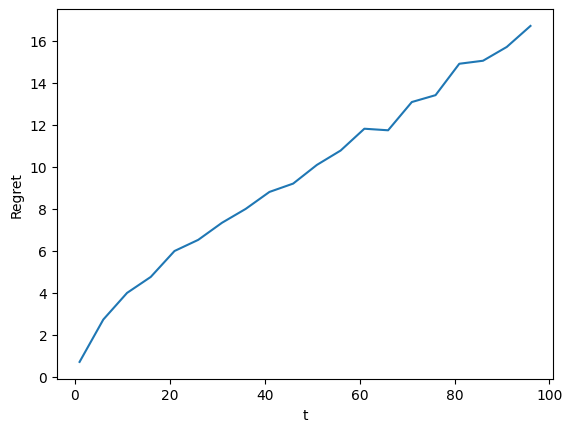

In [10]:
mab.visualize_regret_UCB(MAB, T)

Le regret évolue plus rapidement au départ mais se stabilise rapidement et semble augmenter linéairement. De plus, le regret maximal est plus faible que pour la solution naive.

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des valeurs de $(X_a)_a$ et de $(B_a)_a$ au cours du temps**

Ici, c'est à vous de réfléchir à la meilleure représentation de ces valeurs.

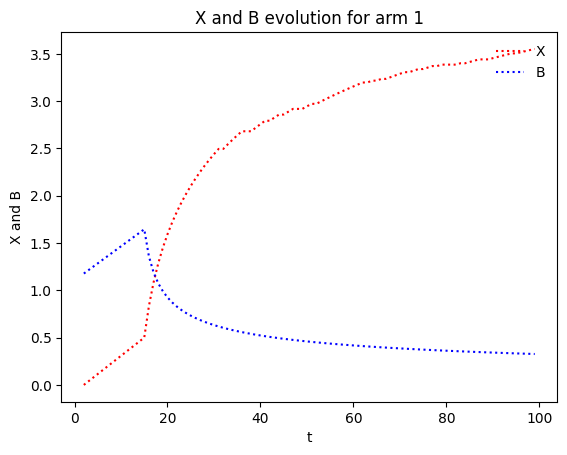

In [16]:
mab.plot_UCB_values(MAB, T, 1)

Voici le graphe représentant,  pour le vaccin 1, l'évolution des valeurs de $(X_a)_a$ et de $(B_a)_a$ au cours du temps (patients).  
Nous pouvons remarquer que la récompense détenue dans X augmente et le biais diminue au fur et à mesure que la certitude de l'efficacité du vaccin augmente.

# Echantillonnage de Thomson

L'algorithme de Thompson calcule à chaque instant $t$ le paramètre des lois Beta pour tous les vaccins. Il échantillonne alors une probabilité de choisir chaque vaccin et choisit le vaccin avec la plus grande probabilité.

**Comment fonctionnent les lois Beta ? Comment les mettre à jour selon les résultats des vaccins ?**

Les lois Beta sont des distributions de probabilité continues qui sont souvent utilisées pour modéliser des variables aléatoires dont la plage de valeurs est entre 0 et 1, ce qui les rend appropriées pour modéliser des probabilités. La distribution Beta est définie par deux paramètres, généralement notés α (alpha) et β (bêta), et elle a une forme qui dépend de ces paramètres. Voici comment est mise à jour la distribution dans le contexte de l'échantillonnage de Thompson pour les vaccins :  

***Fonctionnement de la distribution Beta pour une variable aléatoire continue x dans l'intervalle [0, 1]:***

Si α = β = 1, la distribution Beta est une distribution uniforme sur l'intervalle [0, 1].
Plus α est grand, plus la distribution est concentrée autour de 1.
Plus β est grand, plus la distribution est concentrée autour de 0.
Mise à jour de la distribution Beta : Dans le contexte de l'échantillonnage de Thompson pour les vaccins, chaque vaccin est associé à une distribution Beta. Initialement, α et β sont tous deux fixés à 1 pour chaque vaccin.

Lorsqu'un patient reçoit un vaccin, il obtient une récompense binaire, généralement 1 s'il est guéri et 0 s'il ne l'est pas.

Si le patient guérit (récompense = 1) après avoir reçu un vaccin particulier, les paramètres α et β de la distribution Beta de ce vaccin sont mis à jour comme suit :

**$α_j$ = $α_j$ + 1 (où j est l'indice du vaccin choisi)**  
Si le patient ne guérit pas (récompense = 0) après avoir reçu un vaccin particulier, les paramètres α et β de la distribution Beta de ce vaccin sont mis à jour comme suit :

**$β_j$ = $β_j$ + 1 (où j est l'indice du vaccin choisi)**  
Ces mises à jour reflètent l'idée que lorsque nous observons une récompense positive (guérison), nous augmentons α pour indiquer que ce vaccin est potentiellement plus efficace, et lorsque nous observons une récompense négative (pas de guérison), nous augmentons β pour indiquer que ce vaccin est potentiellement moins efficace.

**Comment se passent l'exploration et l'exploitation ?**

Dans la même idée que la méthode Upper Confidence Bounds, l'exploration et l'exploitation se font en même temps. En effet, l'exploration est faite par la distribution Beta qui permet de tester les vaccins et l'exploitation est faite par le choix du vaccin avec la plus grande probabilité.

**Implémentez l'algorithme et tracez l'évolution du regret.**

In [12]:
print(f"Score: {mab.simulate_thomson(MAB, T)/100}")

Score: 0.67


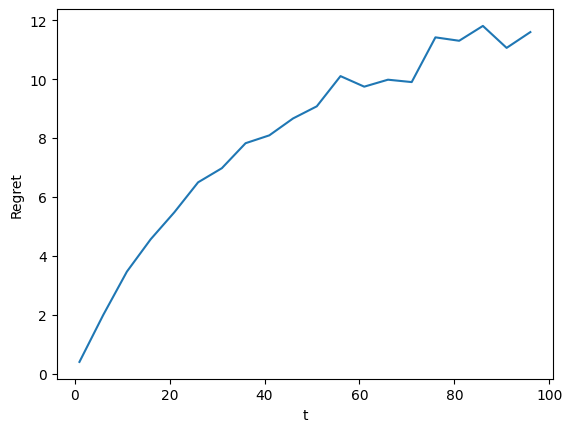

In [13]:
mab.visualize_regret_thomson(MAB, T)

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des probabilités au cours du temps**

Indice : pour représenter des probabilités, on pourra utiliser des diagrammes en violons.

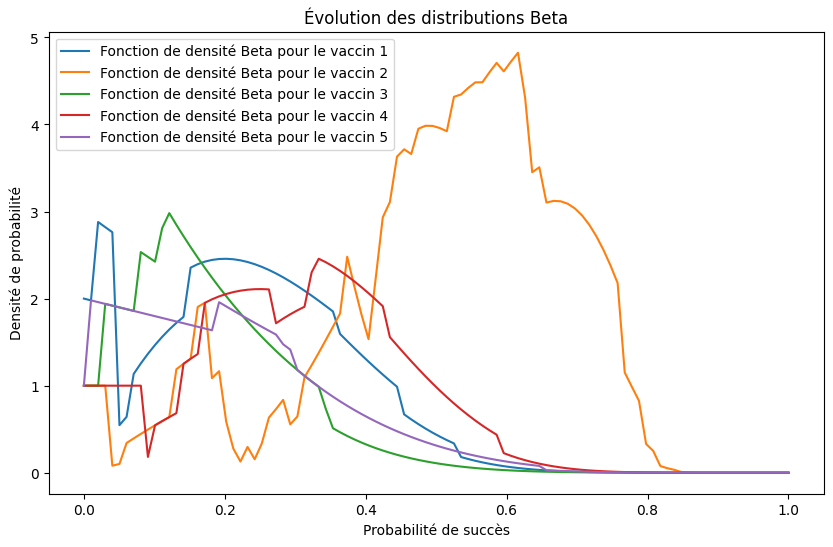

In [14]:
thompson_sampler = mab.ThompsonSampling(K)

total_rewards = 0
alpha_history = [[] for _ in MAB]
beta_history = [[] for _ in MAB]

for t in range(T):
    chosen_arm = thompson_sampler.select_arm()
    reward = MAB[chosen_arm].sample()
    thompson_sampler.update(chosen_arm, reward)
    total_rewards += reward

    # Enregistrez l'historique des paramètres Alpha et Beta à chaque étape
    for i in range(len(MAB)):
        alpha_history[i].append(thompson_sampler.alpha[i])
        beta_history[i].append(thompson_sampler.beta[i])

# Affichez les évolutions des distributions Beta
mab.plot_beta_distributions(alpha_history, beta_history)


Le maximum de densité de probabilité pour le vaccin 1 se trouve au maximum de la probabilité de succés selon les 4 autres vaccins.  
Essayons de présenter les probabilités avec des diagrammes de violons :

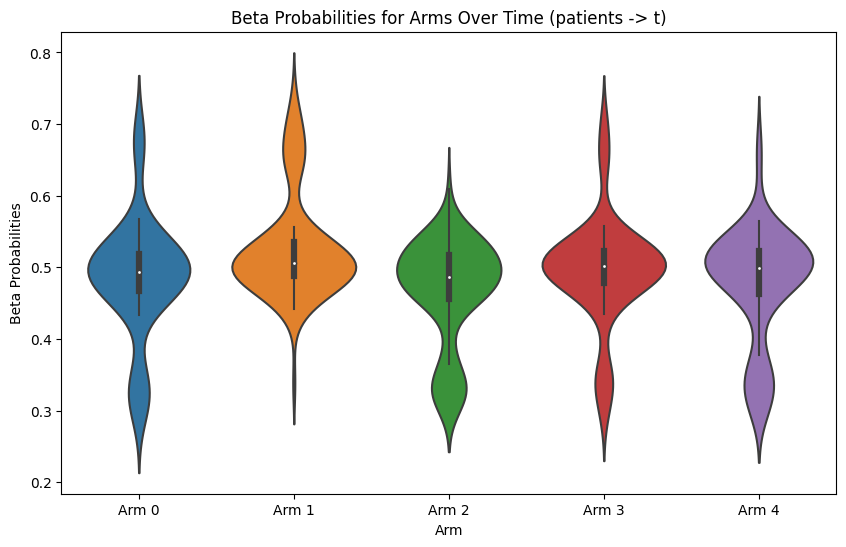

In [15]:
mab.visualize_beta_probabilities(MAB, T)

The violin mean is higher for the second vaccine, and its upper quartile range is higher than the others.